In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install keras

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

## Importing Dataset
The dataset which we will use here has been taken from – https://www.kaggle.com/competitions/dog-breed-identification/data. This dataset includes 10,000 images of 120 different breeds of dogs. In this data set, we have a training images folder. test image folder and a CSV file that contains information regarding the image and the breed it belongs to.

In [ ]:
from zipfile import ZipFile
data_path = '/content/drive/MyDrive/dog-breed-identification.zip'

with ZipFile(data_path, 'r') as zip:
	zip.extractall()
	print('The data set has been extracted.')

The data set has been extracted.


In [ ]:
df = pd.read_csv('/content/dog-breed-identification/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
df.shape

(10222, 2)

In [ ]:
df['breed'].nunique()

120

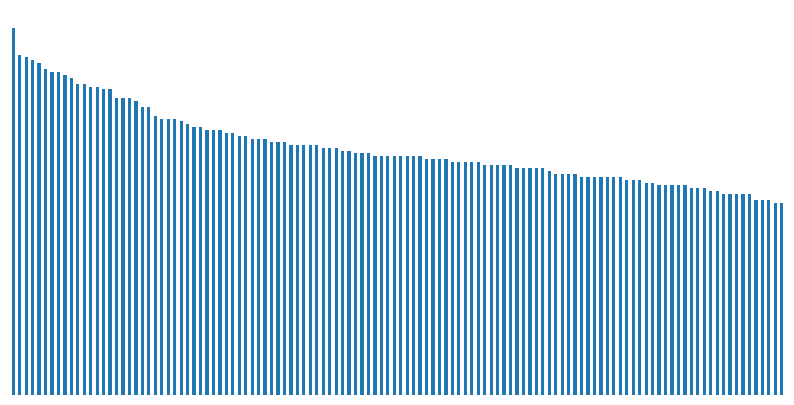

In [ ]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()

In [ ]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


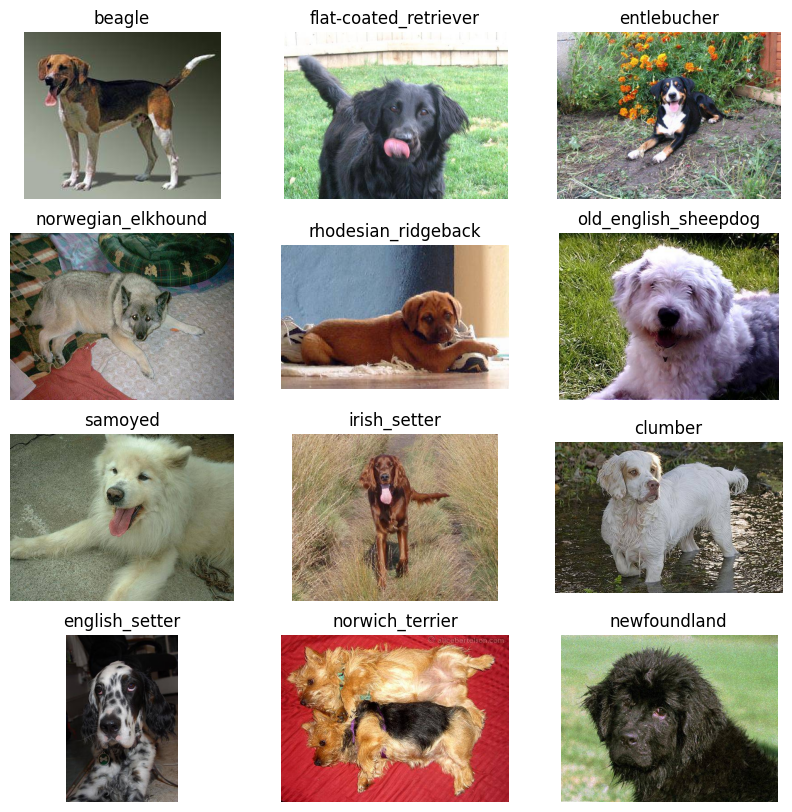

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)

    # Selecting a random image index from the dataframe
    k = np.random.randint(0, len(df))
    img_path = '/content/dog-breed-identification/' + str(df.loc[k, 'filepath'])
    # Check if the file path exists
    if True:
        # Read the image using OpenCV
        img = cv2.imread(img_path)

        # Check if the image was loaded correctly
        if img is not None:
            # Convert from BGR (OpenCV) to RGB (matplotlib)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(df.loc[k, 'breed'])
            plt.axis('off')
        else:
            print(f"Error loading image at {img_path}")
            plt.axis('off')  # Ensure layout is still maintained
    else:
        print(f"File not found: {img_path}")
        plt.axis('off')

plt.show()


In [ ]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


## Image Input Pipeline
There are times when the dataset is huge and we will be unable to load them into NumPy arrays in one go. Also, we want to apply some custom functions to our images randomly and uniquely such that the images with change do not take up disk space. In such cases image input pipelines build using tf.data.Dataset comes in handy.

In [ ]:
features = df['filepath']
target = df['breed']

X_train, X_val,	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape


((8688,), (1534,))

In [ ]:
import albumentations as A

transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])

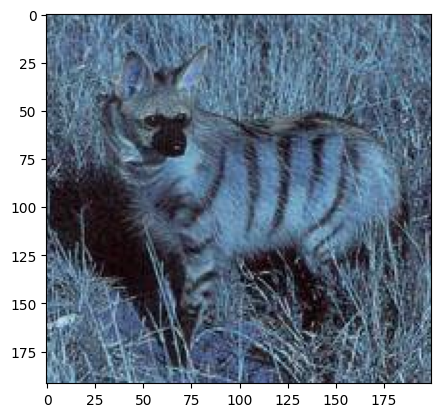

In [ ]:
img = cv2.imread('/content/dog-breed-identification/train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(img)
plt.show()

In the above image, we will apply VerticalFlip, HorizontalFlip, CoarseDropout, and CLAHE albumentation technique and check what changes have been done in the image.

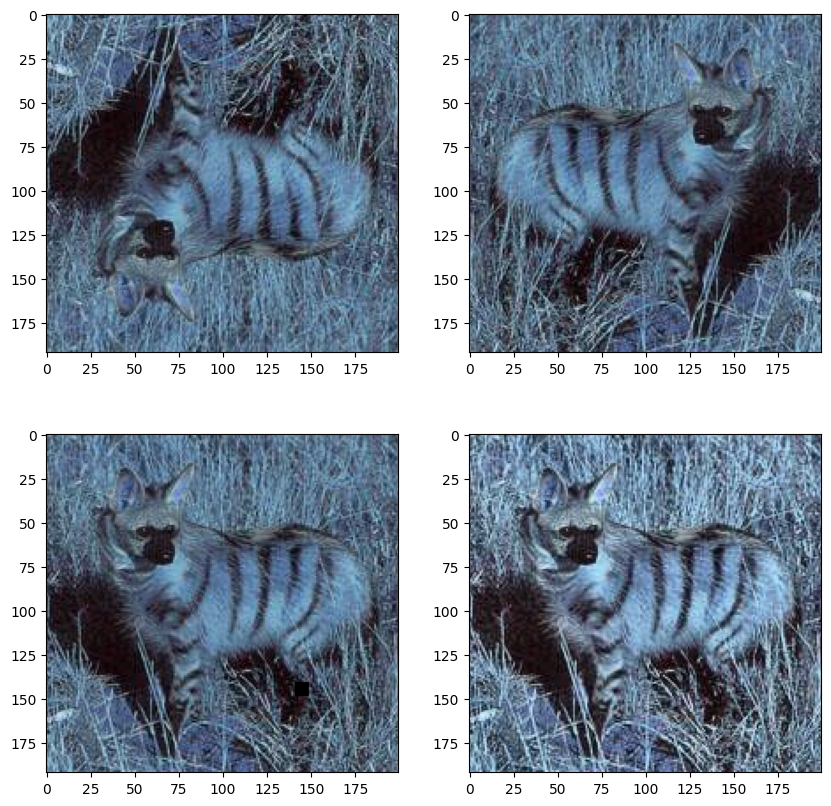

In [ ]:
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
            A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
    plt.subplot(2, 2, i+1)
    aug_img = aug(image=img)['image']
    plt.imshow(aug_img)
plt.show()


Below we have implemented some utility functions which will be used while building the input pipeline.

- decode_image – This function will read the image from the path and resize them to be of the same size along with it will normalize as well. Finally, we will convert the labels into one_hot vectors as well.
- process_data – This is the function that will be used to introduce image augmentation to the image.

In [ ]:
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']
    return aug_img

@tf.function
def process_data(img, label):
    aug_img = tf.numpy_function(aug_fn,
                                [img],
                                Tout=tf.float32)
    return img, label


def decode_image(filepath, label=None):
    path = '/content/dog-breed-identification/'+ filepath
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label == None:
        return img

    return img, tf.one_hot(indices=label,
                           depth=120,
                           dtype=tf.float32)


In [ ]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


In [ ]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)

(32, 128, 128, 3) (32, 120)


## Model Development
We will use pre-trained weight for an Inception network which is trained on imagenet dataset. This dataset contains millions of images for around 1000 classes of images.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
len(pre_trained_model.layers)

311

This is how deep this model is this also justifies why this model is highly effective in extracting useful features from images which helps us to build classifiers. The parameters of a model we import are already trained on millions of images and for weeks so, we do not need to train them again.

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


## Model Architecture
We will implement a model using the  Functional API of Keras which will contain the following parts:

- The base model is the Inception model in this case.
- The Flatten layer flattens the output of the base model’s output.
- Then we will have two fully connected layers followed by the output of the flattened layer.
- We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
- The final layer is the output layer which outputs soft probabilities for the three classes.

In [ ]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.AUC()]
)

## Callback
Callbacks are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like ReduceLROnPlateau decreasing the learning rate further? Even then if model performance is not improving then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
            print('\n Validation accuracy has reached upto 90% so, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=5,
                monitor='val_auc',
                restore_best_weights=True,
                mode='max')

lr = ReduceLROnPlateau(monitor='val_loss',
                    patience=3,
                    factor=0.5,
                    verbose=1)

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - auc: 0.9912 - loss: 1.2836 - val_auc: 0.9466 - val_loss: 2.2661 - learning_rate: 1.9531e-06
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - auc: 0.9923 - loss: 1.2281 - val_auc: 0.9481 - val_loss: 2.2513 - learning_rate: 1.9531e-06
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - auc: 0.9927 - loss: 1.2133 - val_auc: 0.9486 - val_loss: 2.2412 - learning_rate: 1.9531e-06
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - auc: 0.9934 - loss: 1.1913 - val_auc: 0.9488 - val_loss: 2.2330 - learning_rate: 1.9531e-06
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - auc: 0.9931 - loss: 1.1733 - val_auc: 0.9490 - val_loss: 2.2271 - learning_rate: 1.9531e-06
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - auc: 0.9925 - loss: 1.1692 - val_auc: 0.9492 - val_loss: 2.2200 - learning_rate: 1.9531e-06
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - auc: 0.9930 - loss: 1.1485 - val_auc: 0.9493 - va

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,auc,loss,val_auc,val_loss,learning_rate
0,0.993383,1.145851,0.946588,2.266054,0.000002
1,0.994044,1.108116,0.948109,2.251338,0.000002
2,0.993944,1.092896,0.948613,2.241248,0.000002
3,0.994722,1.077544,0.948835,2.233031,0.000002
4,0.994646,1.058015,0.949023,2.227126,0.000002
5,0.994671,1.048851,0.949169,2.220042,0.000002
6,0.994371,1.035743,0.949348,2.214849,0.000002
7,0.994891,1.025012,0.949218,2.210304,0.000002
8,0.995245,1.007115,0.949896,2.205355,0.000002
9,0.995243,1.010514,0.949923,2.201526,0.000002


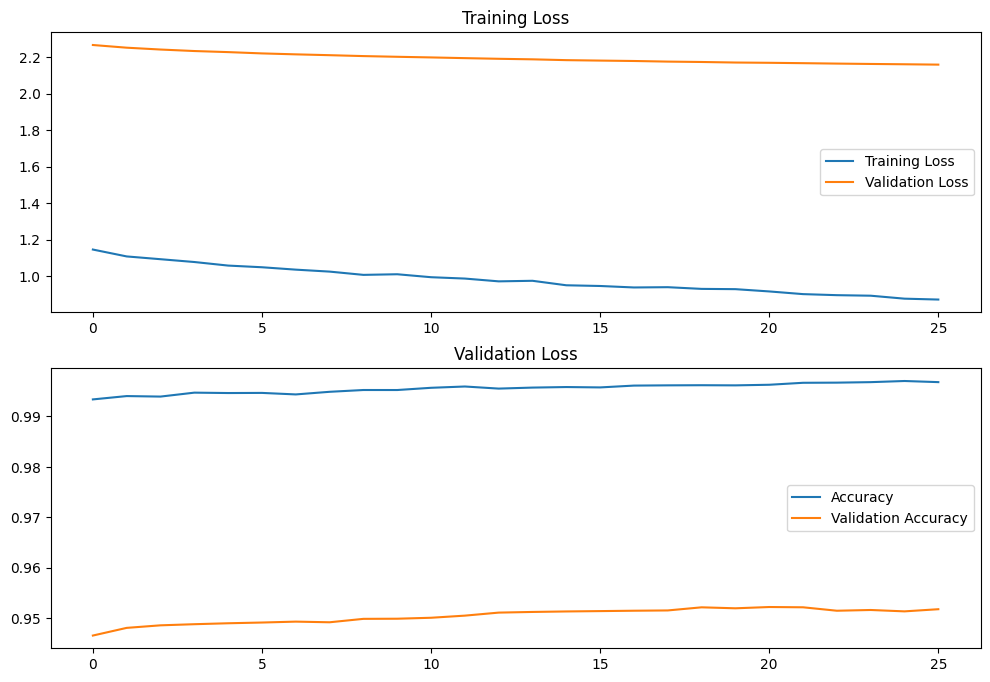

In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 1 row, 2 columns

# Plot training and validation loss
axes[0].plot(history_df.loc[:, ['loss']], label='Training Loss') # Changed axes[0,0] to axes[0]
axes[0].plot(history_df.loc[:, ['val_loss']], label='Validation Loss') # Changed axes[0,0] to axes[0]
axes[0].set_title('Training Loss')
axes[1].plot(history_df.loc[:, ['auc']], label='Accuracy') # Changed axes[1,0] to axes[1]
axes[1].plot(history_df.loc[:, ['val_auc']], label='Validation Accuracy') # Changed axes[1,0] to axes[1]
axes[1].set_title('Validation Loss') #Changed axes[1,0] to axes[1]
axes[0].legend() # Changed axes[0,0] to axes[0]
axes[1].legend() # Changed axes[1,0] to axes[1]

# Show the plot
plt.show()